# Machine Learning Workflow
In this chapter you will get an overview about the workflow for machine learning. In general we are looking from raw data or structurized data in form of tables to our machine learning model. 

You will find a lot of information of this topic in varoius blogs and posts. However here are some sources

["A Survey on Data Collection for Machine Learning"](https://arxiv.org/pdf/1811.03402.pdf)  

by Roh, Yuji and Heo, Geon and Whang, Steven {cite}```Roh2019``` and

["Data Preprocessing for Supervised Learning"](https://www.researchgate.net/profile/P-Pintelas/publication/228084519_Data_Preprocessing_for_Supervised_Learning/links/0c960517fefa258d0d000000/Data-Preprocessing-for-Supervised-Learning.pdf)  

by Kotsiantis, Sotiris and Kanellopoulos, Dimitris and Pintelas, P. {cite}```Kotsiantis2006```.

For finding dataset where you can test you knowledge you can look at

https://archive.ics.uci.edu/ml/index.php or on https://www.kaggle.com/.


## Data Preprocessing 
Before we can start to use the data for our machine learning models, we need to look at the data and preprocess this. In best case we have data in tables with just one category of data types (numerical, categorical, ordinal) and with no missing values. But this is very rare and we have to look on the raw data/tables to see what we will be faced. 
We will create a dataset here to show a non perfect example.

In [195]:
data = {'name': [1,np.nan,"AAA",4,"BBB",5,6],
        'weight': [80,7,45,70,50,np.nan,72],
        'age': [50,52,12,24,18,11,35]}
data

{'name': [1, nan, 'AAA', 4, 'BBB', 5, 6],
 'weight': [80, 7, 45, 70, 50, nan, 72],
 'age': [50, 52, 12, 24, 18, 11, 35]}

The first thing to do is to look at the data in form of a table. The package `pandas` provides a framework for this. We will use this to look at tables and generate first plots.

,name,weight,age
0,1,80.0,50
1,NaN,7.0,52
2,AAA,45.0,12
3,4,70.0,24
4,BBB,50.0,18
5,5,NaN,11
6,6,72.0,35


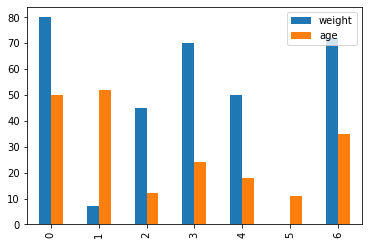

In [203]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.DataFrame(data)
df.plot(kind="bar")
df

### Handling missing values
Now we can see the data. We have different kind of values and type of data. We have 3 columns with different data types inside. We have missing values "NaN: Not a Number" and we have strings "AAA" inside the first column. We can drop all rows where a NaN is present. We could also fill NaNs with the mean of the whole column. For column 2 "Age" we can do this. But what is about column 1 "name"? Do the column name will give some information? 

In [102]:
df_dropped = df.dropna()
df_dropped

,name,weight,age
0,1,80.0,50
2,AAA,45.0,12
3,4,70.0,24
4,BBB,50.0,18
6,6,72.0,35


To drop all rows with missing information is often not a good idea. We would lose too much data. In this case we lost two from our 8 data points, which is huge. We also lost information because the "name" column had a missing value. For now we will drop the "name" column because it will not give any insights despite some kind of index. But we will instead use the build in index from `pandas` dataframe. Instead of dropping all rows with missing value, we just can give value to the missing ones. This is called imputing and we can use `scikit-learn` library for this. We can fill missing values with mean, median, most-frequent or constant values. There are also technique which will use correlated features to get a better imputing value, for example stochastic regression imputation.

In [230]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(df[["weight"]])
df['weight'] = imputer.transform(df[['weight']])
df

,name,weight,age
0,1,80.0,50
1,NaN,7.0,52
2,AAA,45.0,12
3,4,70.0,24
4,BBB,50.0,18
5,5,54.0,11
6,6,72.0,35


### Outlier detection
The next step is to check the valid values for meaningfulness. This is also known as outlier detection. We can either do this by hand in small datasets or use statistics method or even use unsupervised learning techniques to achieve this. As a statistical method we can use standard deviation cutoff method, where we say every value outside 3 times standard deviation is an outlier.

We can use unsupervised machine learning techniques for example one cluster methods like Support Vector Machine (which we will handle later in this lecture). For our toy dataset we will start to look for outliers by hand. We quickly see that a weight of "7" does not seem very reasonable for a "52" year old person. However, we will try a statistical method, a standard deviation cutoff. There we will see that the "7" is within 3 times a standard deviation and even worse in the 2 times interval. For this tool it is necessary to have a dataset which is more "normal" and drawn from Gaussian distribution. 

In [219]:
data_mean, data_std = np.mean(df), np.std(df)
data_mean-3*data_std

weight   -19.095828
age      -18.777950
dtype: float64

Another technique which require less normal sampled dataset is a interquantile range method. We define the middle 50% of the data as the inter quantile range. We will say that all data is outside which is 1.5 times the inter quantile range above the 75% and lower the 25% quantile. Here we will see that our by hand identified outlier is outside the lower threshold.

In [252]:
q25, q75 = np.percentile(df[["weight"]], 25), np.percentile(df[["weight"]], 75)
iqr = q75 - q25

cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off

print("lower bound: ",lower, "upper bound: ",upper)

lower bound:  12.25 upper bound:  106.25


Another mentioned technique is the one class SVM. This is not easy to handle because we have to set a "kernel", a $\gamma$ and $\nu$ which are the hyperparameters of the SVM. The plot underneath shows the result where we can see that one data point (blue) is far away from the others(yellow). But to find these parameters is often exhausting.

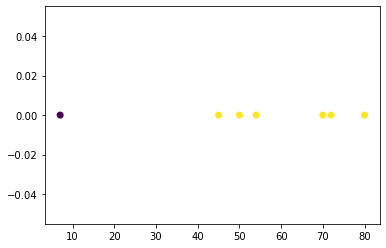

In [272]:
from sklearn import svm
X = df[["weight"]]
#x_scaled = StandardScaler().fit_transform(X)
x_scaled = X
out = OneClassSVM(kernel="linear", gamma="auto", nu=0.1).fit(x_scaled)
plt.scatter(x_scaled,np.zeros([7]),c=out.predict(x_scaled))



### Feature selection
The next step is to reduce input variable to the most useful ones or at least which we believe which are the most useful ones. We want to drop as much irrelevant and redundant data as possible. This section will give an overview about feature selection. We will focus on two methods, Filter based and wrapper based methods.

Wrapper Methods:
In general wrapper methods create many models with different subsets of input features. Then select those features which performs best according to a performance metric. As example we can refer to **recursive feature elimination** (RFE): "https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html"

Filter Methods:
In filter selection methods we use statistical techniques to evaluate the correlation between each input variable and a target variable. Methods to note for numerical input/output are **Pearson’s correlation coefficient** for linear relationship, **Spearman’s rank coefficient** for nonlinear relationship and for categorical input/output are **Chi-Squared test** and **Mutual Information score**.

Methods to note:
Decision Trees have a build in feature selection during the training.

Feature selection reduces the number of feature whereas dimensionality reduction create a projection of the data in a less dimensional subspace. For this topic we recommend to look on: Autoenconder Methods, Principal Component Analysis (PCA) or Manifold Learning.


### Scaling 
The effects of scaling is to better compare results for the user and the machine learning technique. In distance-based algorithms it is necessary to scale the features. So the distances can be compared. Moreover scaled data can help to perform better in the optimization process. We only have one learning rate for all features. With different features with highly different ranges we could need a small step size to not overshoot in one axis but just taking mini steps in the other axis.

Standardization: 

$$
X' = \frac{X - X_{min}}{X_{max}-X_{min}}
$$

This is also know as Min/Max Scaling.

Normalization: 

$$
X' = \frac{X - \mu}{\sigma}
$$

scaling with mean $\mu$ and standart deviation $\sigma$, use this when the data is drawn from gaussian distribution.


In [270]:
X = df[["weight", "age"]]
x_scaled = StandardScaler().fit_transform(X) #Normalization
x_scaled


array([[ 1.15259149,  1.33155134],
       [-2.08353078,  1.4575089 ],
       [-0.39897398, -1.06164229],
       [ 0.70928707, -0.30589693],
       [-0.17732177, -0.68376961],
       [ 0.        , -1.12462107],
       [ 0.79794796,  0.38686965]])

In [271]:
X = df[["weight", "age"]]
x_scaled = MinMaxScaler().fit_transform(X) #Standardization aka MinMax Scaler
x_scaled


array([[1.        , 0.95121951],
       [0.        , 1.        ],
       [0.52054795, 0.02439024],
       [0.8630137 , 0.31707317],
       [0.5890411 , 0.17073171],
       [0.64383562, 0.        ],
       [0.89041096, 0.58536585]])

### Imbalanced Data
The last part of preprocessing is to check for imbalanced data. For example you have an event which only occurs in 1% of your data. This means if you would now split your train and test data it could happen that none of the 1% is in the training data or vise versa. Even if all of the 1% is in the training data, this is only a fraction of all events and could lead to the result that the algorithm did not pay enough attention to this rare event.

To overcome this negative results we can use one of the following:

- Under sampling: randomly eliminate the majority class data points. Then use a dataset where all important events are balanced.
- Over sampling: increase the minority class by randomly copying the rare events.
- Ensemble different resampled datasets: Train $n$ different models which have all the minority class samples and always different majority class.
- Adjust your ML method instead of the data: You can adjust the cost function in your algorithm that the minority class has more impact.

**Preprocessing Cheat Sheet**

|    Issues   |   what to do   |
| :------------ | -------------: |
| Look at data / Visualize the data | use of dataframes and tables / visualize with plots |
| Handling NaNs | drop every row with a NaN / Imputing techniques |
| Outliers detection   | statistical tools / unsupervised Learning algorithms / remove bad data by hand |
| Feature selection   | keep one feature and drop high correlated features / supervised techniques:Filter(pearson Coefficent, Chi squared, Anova), Wrapper(genetic algorithms/RFE)|
| Scaling   | scale the data for better comparability(for you and your algorithm) / Normalization / Standardization|
| Imbalanced data   | use small batches (ensemble different resampled datasets) / over - under-sampling /adjust your ML technique|

## Model selection
Now we will dive into the Machine Learning part. We will look deeper into model selection techniques. We are looking for a model that has enough explanatory power to explain the variance in the data without over- or under-fitting, yet is parsimonious. We already showed regularization in form of LASSO and Ridge Regression to overcome overfitting in previous chapter and will continue on statistical and information based model selection. Before this we will take a look on different metrics for classification, regression and clustering and will make clear some various definitions.

### Metrics

**Classification**
```{list-table} Confusion Matrix
:header-rows: 1
* - 
  - real Positive
  - real Negative  
* - Predicted Positive
  - True Positive (TP)
  - False Negative (FN)
* - Predicted negative
  - False Positive (FP)
  - True Negative (TN)
```
Accuracy is the probability that prediction(positive or negative) is correct

$$
ACC = \frac{TP+TN}{TP+TN+FN+FP}
$$

precision is probability that positive class prediction is correct

$$
PRC = \frac{TP}{TP+FN}
$$

recall is probability that positive class is correctly predicted

$$
REC = \frac{TP}{TP+FN}
$$

$F_1$-score is harmonic mean of precision and recall

$$
REC = \frac{2TP}{2TP+FP+FN}
$$

Optimally you want a model that predict both the correct, the precision and the recall which is simply the $F_1$-score. 

Mentioned other metrics for classification: Cross-entropy, Area under the receiver operating characteristic (ROC) Curve (AUC). 

**Regression**

Already in optimizatin explained is the residual sum of squares (RSS) which can be related to mean sqaured error (MSE). The MSE and the root mean squared error is defined as

$$
MSE = \frac{1}{n}\sum_{i=1}^n(y_i-\hat y_i)^2 \newline
RSME = \sqrt{MSE}
$$
with $y$ is the real value and $\hat y$ is the prediction from our model.

Another popular metric is the R-squared or adjusted R-squared

$$
R^2 = 1-\frac{SS_{regression}}{SS_{total}} = 1-\frac{\sum_i(y_i-\hat y_i)}{\sum_i(y_i-\bar y_i)}
$$
where $\bar y_i$ is the mean of the data. To interpret these value we will look at a picture from wikipedia.
<a href="https://de.wikipedia.org/wiki/Bestimmtheitsma%C3%9F"> <center><img src="https://upload.wikimedia.org/wikipedia/commons/4/4a/R2values.svg" style="width: 150px;"></center></a>

**Clustering**
For clustering techniques we will refer to silhoutte score, (adjusted) rand index and mutual information score.

### Statistical and information based model selection
Occam's razor says optimal models are as parsimonious as possible. For this we need a formal method to select the optimal model that provides the best trade-off between variance and bias. We can answer this with hypothesis testing.

**Likelihood ratio test** can be used for nested models $M_0 \subset M_1$. For this we can use Wilk's Theorem with the Chi-squared distribution. For example in polynomial regression where the model with higher polynomial degree includes the model with lower degrees is a nested model. We can make a t-statistic and like a t-test we can calculate a p-value to drop our hypothesis $H_0$ in favor of an alternative hypothesis $H_1$ or believe in $H_0$ when the p-values is under a given threshold.

**Akaike's Information Criteria (AIC)** can be used for models with $k$ parameters $\Theta$ and a likelihood function  $\log(\mathcal{L}(\Theta|x))$ and is defined as 

$$
AIC:= 2k - 2\log(\mathcal{L}(\Theta|x))
$$

This score of a model can be seen as an estimate of expected information loss if we replace the true data by the prediction of our model. By minimizing this we finding the optimal model. 

Other techniques to notes are Bayesian Information Criterion (BIC) and Minimum Description Length (MDL).

### Sampling / Resampling based model selection

**Cross Validation**

In cross validation techniques we will partition the dataset $D$ in training and hold-out/test sets. More precise in **k-fold cross validation** we will split the data into $k$ equally sized folds $D_i$. Then we train $k$ models with $k-1$ training sets and $1$ test set. But in each model we will change the test set, that we will get different results. With a given metric for example Root Mean Square Error (RMSE), we can compute an average model accuracy.

<a href="https://en.wikipedia.org/wiki/Cross-validation_(statistics)"> <center><img src="https://upload.wikimedia.org/wikipedia/commons/c/c7/LOOCV.gif" style="width: 80px;"></center></a>

We can now look at the average accuracy of our models which we trained a took these with the minimum. This cross-validation technique allows us to address our model selection problem by means of a comparison of the (cross-validated) accuracy (i.e. the prediction performance) of our models. A major benefit of cross-validation approach is that it is a simple numerical approach that generally works for arbitrary machine learning techniques, as long as 1. we can derive a prediction from a model that we can validate in our test set, and 2. we have enough data to  apply a cross-validation. A similar technique is **leave one out cross validation (LOOCV)** where we have the issue that we have not a big dataset and rather have for example 20 data points. There we would make a cross validation with $k=20$ folds and just leave one sample out.

**Bootstrapping** 

In the other case that we have a huge datasets, where model training or even plotting can take some time we want to take not all of the samples. For this we can refer to bootstrap algorithms. In these we draw $n$ samples with replacement from the whole dataset - in contrast to cross validation holdout which is without replacement. We now train a model for each of these bootstrap sets and compute a metric (accuracy, RSME). We now compute the overall metric as the mean of each individual bootstrap metric. But bootstrapping is even more, we assume that we take samples from a normal distribution $\mathcal{N}(\mu,\sigma^2)$ with unkown mean $\mu$ and variance $\sigma^2$. We can estimate the mean and the variance by the data. Out of this assumption we can calculate a standard error and a 95% interval for the metric(accuracy). We now have a feeling for a values of the accuracy and can estimate if our model is good. If we are unsure about the samples if it follows a normal distribution we could use percentile method.

## References

```{bibliography}
:filter: docname in docnames
:style: plain
```